In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
from torchvision.models import resnet50
from PIL import Image
import pandas as pd
import os
from torchvision.models.resnet import ResNet50_Weights
from tqdm import tqdm
import numpy as np

import sklearn
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import shutil

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/kunkerdthaisong/.netrc


True

In [22]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

wandb: Currently logged in as: kun-kerdthaisong (my_lab). Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


acc,▂▁▅▇█▆▇█
loss,█▆▂▄▂▂▁▂
acc,0.97996
loss,0.09282


In [4]:

model=torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT) #change weights to my finetuned
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs,3)
model.load_state_dict(torch.load("/Users/kunkerdthaisong/cils/flooded_road/exp02.pt"))
model.eval() #like with torch.no_grad()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
class CustomDataset(Dataset):
    def __init__(self, df=pd.DataFrame(), transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name =self.df.iloc[index, 0]
        image = Image.open(img_name)
        label = int(self.df.iloc[index, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
test_df=pd.read_csv("/Users/kunkerdthaisong/cils/test_3level.csv")

In [7]:
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

test_dataset = CustomDataset(test_df, transform=transform)

In [8]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
pred=[]
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs, labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        pred.append(np.asarray(predicted.squeeze(0)))

In [10]:
pred

[array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1]), array([1, 1])]

In [11]:
n=0
x=pred[0]
while n<len(pred)-1:
    x=np.concatenate((x,pred[n+1]), axis=None)
    n+=1
x

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1])

In [13]:
type(model)

torchvision.models.resnet.ResNet

In [11]:
test_df["pred"]=x

In [17]:
confusion_matrix(test_df["class"],test_df["pred"],normalize='true').T

array([[0.5       , 0.        , 0.        ],
       [0.5       , 0.72727273, 0.        ],
       [0.        , 0.27272727, 1.        ]])

In [17]:
range(1,15)

range(1, 15)

In [22]:
test_df.to_csv("test_look_grad.csv")

In [58]:
pt=pd.DataFrame({"epoch":[i for i in range(1,16)],"loss":[1.121,1.027,0.866,0.920,0.876,0.793,0.756,0.424,0.430,0.652,0.255,0.248,0.234,0.143,0.058],"acc":[0.611,0.222,0.444,0.277,0.500,0.333,0.500,0.388,0.333,0.388,0.500,0.611,0.444,0.555,0.555]})

In [16]:
os.makedirs("a")

In [19]:
np.load("/Users/kunkerdthaisong/cils/flooded_road/training_logs/3/acc_hist.npy")

array([0.66666667])

ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

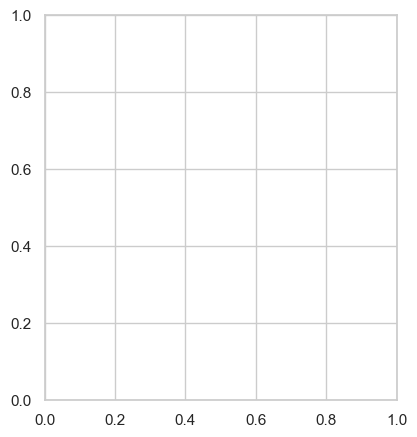

In [18]:
sns.set(style="whitegrid")

# Loss plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,16),np.load("/Users/kunkerdthaisong/cils/flooded_road/training_logs/3/acc_hist.npy"), label='validation acc', marker='o')
plt.title('traning')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.close()